# TF Simple CNN

In [1]:
import tensorflow as tf
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
mnist = fetch_mldata("MNIST original", data_home="/home/saurabh/Documents/python/digits/data")

X_train, X_test, y_train, y_test = train_test_split(mnist.data, label_binarize(mnist.target, classes = range(10)))

In [4]:
print ('Shape of X : {}'.format(X_train.shape))
print ('Shape of y : {}'.format(y_train.shape))

Shape of X : (52500, 784)
Shape of y : (52500, 10)


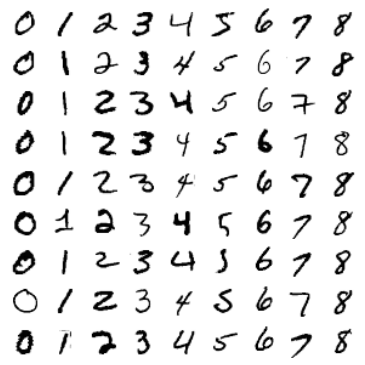

In [14]:
fig = plt.figure(figsize=(7, 7))
for x in range(0, 9):
    for y in range(0, 9):
        ax = fig.add_subplot(10, 10, 10*(y+1)+x + 1)
        index = np.where(mnist.target == x)[0][y]
        ax.imshow(mnist.data[index].reshape((28, 28)))
        ax.axis("off")
        plt.xticks([])
        plt.yticks([])

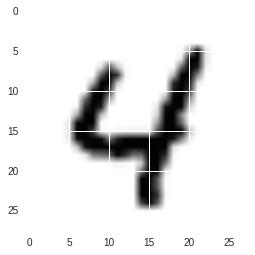

In [5]:
plt.imshow(X_train[1].reshape((28, 28)))

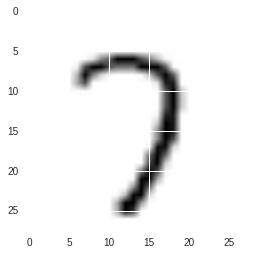

In [6]:
plt.imshow(X_train[3].reshape((28, 28)))

## Build CNN of 5 layers ( conv, bias, relu, pool, out )

In [3]:
def conv_net(X, weights, biases):
    X_reshaped = tf.reshape(X, shape = [-1, 28, 28, 1])
    conv1 = tf.nn.conv2d(X_reshaped, weights["wc1"],
                        strides = [1, 1, 1, 1], padding = "SAME")
    bias_add1 = tf.nn.bias_add(conv1, biases["bc1"])
    relu1 = tf.nn.relu(bias_add1)
    
    conv2 = tf.nn.conv2d(relu1, weights["wc2"],
                        strides = [1, 1, 1, 1], padding = "SAME")
    bias_add2 = tf.nn.bias_add(conv2, biases["bc2"])
    relu2 = tf.nn.relu(bias_add2)
    
    pool = tf.nn.max_pool(relu2, ksize = [1, 2, 2, 1],
                         strides = [1, 2, 2, 1], padding = "SAME")
    one_hot = tf.reshape(pool, [-1, weights["wd1"].get_shape().as_list()[0]])
    out = tf.add(tf.matmul(one_hot, weights["wd1"]), biases["bd1"])
    
    return out

## Build Model

In [4]:
learning_rate = 0.001
n_input = 784
n_output = 10
stddev = 0.1

graph = tf.Graph()
with graph.as_default():
    
    X = tf.placeholder(tf.float32, [None, n_input])
    y = tf.placeholder(tf.float32, [None, n_output])


    weights = {
        "wc1": tf.Variable(tf.random_normal([3, 3, 1, 32], stddev = stddev)),
        "wc2": tf.Variable(tf.random_normal([3, 3, 32, 64], stddev = stddev)),
        "wd1": tf.Variable(tf.random_normal([14*7*128, n_output], stddev = stddev))
    }

    biases = {
        "bc1": tf.Variable(tf.random_normal([32], stddev = stddev)),
        "bc2": tf.Variable(tf.random_normal([64], stddev = stddev)),
        "bd1": tf.Variable(tf.random_normal([n_output], stddev = stddev))
    }
    prediction = conv_net(X, weights, biases)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, y))
    train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    saver = tf.train.Saver()

In [5]:
n_epochs = 10
batch_size = 100
n_batches = int(X_train.shape[0] / batch_size)

np.random.seed(1)
train = []
cv = []
costs = []

with tf.Session(graph=graph) as sess:
    sess.run(tf.initialize_all_variables())
    headers = ["s_no", "time", "cost", "train_accuracy", "cv_accuracy"]
    print "|{0:>5} | {1:>10} | {2:>10} | {3:>15} | {4:>15} |".format(*headers)
    print "|{0:-<5} | {0:-<10} | {0:-<10} | {0:-<15} | {0:-<15} |".format("")
    for epoch in range(n_epochs):
        avg_cost = 0.0
        start_time = datetime.now()
        for _ in range(n_batches):
            indices = np.random.randint(X_train.shape[0], size=batch_size)
            sess.run(train_step, { X: X_train[indices], y: y_train[indices]})
            avg_cost += sess.run(cost, { X: X_train[indices], y: y_train[indices]}) / float(n_batches)
    
        indices = np.random.randint(X_train.shape[0], size=batch_size)
        score_train = sess.run(accuracy, { X: X_train[indices], y: y_train[indices]})
        indices = np.random.randint(X_test.shape[0], size=batch_size)
        score_valid = sess.run(accuracy, { X: X_test[indices], y: y_test[indices]})
        
        end_time = datetime.now()
        print ("|{0:>5} | {1:>6.3} min | {2:>10.2f} | {3:>13.1f} % | {4:>13.1f} % | ".format(
                 epoch + 1, (end_time - start_time).total_seconds() / 60.0, avg_cost, 100 * score_train, 100 * score_valid))
        train.append(score_train * 100)
        cv.append(score_valid * 100)
        costs.append(avg_cost)
    # indices = np.random.randint(X_test.shape[0], size=3000)
    # y_true = np.argmax(y_test[indices], 1)
    # y_pred = np.argmax(prediction.eval({ X: X_test[indices] }), 1)
    # sns.heatmap(confusion_matrix(y_true, y_pred))
    # print "{0:>.1f} %".format(accuracy_score(y_true, y_pred) * 100)
    save_path = saver.save(sess, "saved_models/mnist/CNN_MODEL.ckpt")

| s_no |       time |       cost |  train_accuracy |     cv_accuracy |
|----- | ---------- | ---------- | --------------- | --------------- |
|    1 |   7.87 min |       8.33 |          93.0 % |          96.0 % | 
|    2 |    7.9 min |       0.76 |          97.0 % |          96.0 % | 
|    3 |   8.22 min |       0.36 |          98.0 % |          98.0 % | 
|    4 |   8.19 min |       0.20 |         100.0 % |          99.0 % | 
|    5 |   8.13 min |       0.12 |          98.0 % |          95.0 % | 
|    6 |   8.21 min |       0.09 |         100.0 % |          99.0 % | 
|    7 |   8.01 min |       0.06 |         100.0 % |          96.0 % | 
|    8 |    7.7 min |       0.05 |          99.0 % |          97.0 % | 
|    9 |   7.61 min |       0.04 |          98.0 % |          98.0 % | 
|   10 |   7.63 min |       0.04 |         100.0 % |          99.0 % | 


In [9]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, "saved_models/CNN_MODEL.ckpt")
    indices = np.random.randint(X_test.shape[0], size=3000)
    y_true = np.argmax(y_test[indices], 1)
    y_pred = np.argmax(prediction.eval({ X: X_test[indices] }), 1)
    sns.heatmap(confusion_matrix(y_true, y_pred))
    print "{0:>.1f} %".format(accuracy_score(y_true, y_pred) * 100)

ValueError: Restore called with invalid save path saved_models/CNN_MODEL.ckpt

In [11]:
with tf.Session(graph=graph) as sess:
    tf.train.write_graph(sess.graph_def, "saved_graphs/mnist", "cnn.pb")

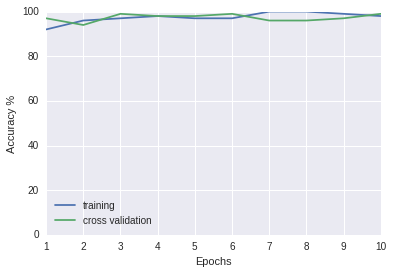

In [31]:
points = {
    "epoch": range(1, len(train) + 1),
    "train": train,
    "cv":    cv
}

plt.plot(points["epoch"], points["train"])
plt.plot(points["epoch"], points["cv"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.ylim((0, 100))
plt.legend(["training", "cross validation"], loc="lower left")

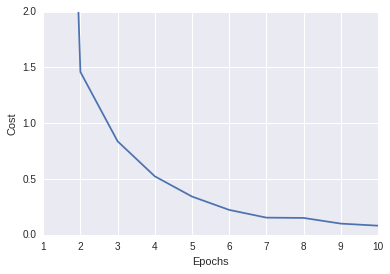

In [32]:
points = {
    "epoch": range(1, len(costs) + 1),
    "cost": costs
}

plt.plot(points["epoch"], points["cost"])
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.ylim((0, 2));